# Threshold Playground – Per‑Station Flood Tuning
*Generated 2025-08-07 13:10*

This notebook starts from the **v4 per‑station XGB models** (70 / 30 split) and lets you
interactively test decision thresholds for each station until you’re happy with the
false‑positive / false‑negative trade‑off.

In [1]:
# Auto‑install xgboost if needed
import importlib, subprocess, sys, warnings, os, datetime
if importlib.util.find_spec('xgboost') is None:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "xgboost"])
warnings.filterwarnings('ignore')


In [2]:
import pandas as pd, numpy as np
from pathlib import Path
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt


In [3]:
# CONFIG – adjust if your folder names differ
PROJECT_ROOT = Path.cwd() if (Path.cwd()/'data').exists() else Path.cwd().parent
DATA_RAW = PROJECT_ROOT/'data'/'raw'
STATIONS = ['D08A071','D08A084','D08A115']
ROLL_WINDOWS=[3,6,12]
LAG_HRS=range(1,13)
API_WINDOW=24*7
PERCENTILE=0.82            # original v4 flood definition
SEED=42


In [4]:
def load_station(code):
    csv = list((DATA_RAW/f'station_{code}').glob('*.csv'))[0]
    df = pd.read_csv(csv)
    df['datetime'] = pd.to_datetime(df['saatlik'])
    df = (df.rename(columns={'yagis_toplam':'rain_mm','qdeger':'discharge_cms'})
            .set_index('datetime').sort_index()
            .resample('h').agg({'rain_mm':'sum','discharge_cms':'mean'}))
    return df

def build_features(df):
    st=df.copy()
    for w in ROLL_WINDOWS:
        st[f'rain_sum_{w}h']=st['rain_mm'].rolling(w,1).sum()
    for l in LAG_HRS:
        st[f'dis_lag_{l}h']=st['discharge_cms'].shift(l)
    st['dis_rate_1h']=st['discharge_cms'].diff(1)
    st['dis_rate_3h']=st['discharge_cms'].diff(3)
    st['API7']=st['rain_mm'].rolling(API_WINDOW,1).sum()
    st.dropna(inplace=True)
    thr = st['discharge_cms'].quantile(PERCENTILE)
    st['flood'] = (st['discharge_cms']>thr).astype(int)
    return st


## 1. Fit per‑station XGB models & save test probabilities

In [5]:
probs_dict = {}
ytrue_dict = {}
MODELS = {}

for code in STATIONS:
    df = build_features(load_station(code))
    cols = [c for c in df.columns if c.startswith(('rain_sum','dis_lag','dis_rate','API'))]
    split = int(len(df)*0.7)           # 70/30 chronological
    X_train, y_train = df.iloc[:split][cols],  df.iloc[:split]['flood']
    X_test,  y_test  = df.iloc[split:][cols], df.iloc[split:]['flood']

    neg,pos = np.bincount(y_train)
    clf = XGBClassifier(
        learning_rate=0.05, n_estimators=800, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, random_state=SEED,
        scale_pos_weight=neg/pos, eval_metric='aucpr'
    )
    clf.fit(X_train, y_train)

    MODELS[code] = clf
    probs_dict[code] = clf.predict_proba(X_test)[:,1]
    ytrue_dict[code] = y_test

print("Saved probability vectors for:", list(probs_dict.keys()))


Saved probability vectors for: ['D08A071', 'D08A084', 'D08A115']


## 2. Helper utilities

In [6]:
def eval_thr(code, thr):
    probs = probs_dict[code]
    y     = ytrue_dict[code]
    pred  = (probs > thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, pred, labels=[0,1]).ravel()
    prec = precision_score(y, pred, zero_division=1)
    rec  = recall_score(y, pred, zero_division=0)
    return fp, fn, prec, rec

def plot_hist(code):
    probs = probs_dict[code]
    y     = ytrue_dict[code]
    plt.figure(figsize=(4,2))
    plt.hist(probs[y==0], bins=50, alpha=0.4, label='non‑flood')
    plt.hist(probs[y==1], bins=50, alpha=0.4, label='flood')
    plt.title(f"{code} – probability distribution")
    plt.legend(); plt.show()


### Example: inspect distributions & try thresholds

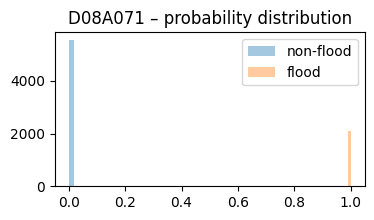

== D08A071 ==
thr= 0.01  FP=4   FN=0    prec=0.998  rec=1.000
thr= 0.05  FP=3   FN=0    prec=0.999  rec=1.000
thr=  0.1  FP=3   FN=0    prec=0.999  rec=1.000
thr=  0.5  FP=2   FN=1    prec=0.999  rec=1.000
thr=  0.9  FP=1   FN=1    prec=1.000  rec=1.000
thr= 0.95  FP=1   FN=1    prec=1.000  rec=1.000
thr= 0.98  FP=1   FN=1    prec=1.000  rec=1.000
thr=0.995  FP=1   FN=1    prec=1.000  rec=1.000



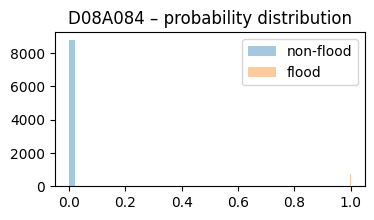

== D08A084 ==
thr= 0.01  FP=42  FN=0    prec=0.947  rec=1.000
thr= 0.05  FP=28  FN=0    prec=0.964  rec=1.000
thr=  0.1  FP=25  FN=0    prec=0.968  rec=1.000
thr=  0.5  FP=6   FN=0    prec=0.992  rec=1.000
thr=  0.9  FP=3   FN=0    prec=0.996  rec=1.000
thr= 0.95  FP=2   FN=1    prec=0.997  rec=0.999
thr= 0.98  FP=2   FN=1    prec=0.997  rec=0.999
thr=0.995  FP=2   FN=1    prec=0.997  rec=0.999



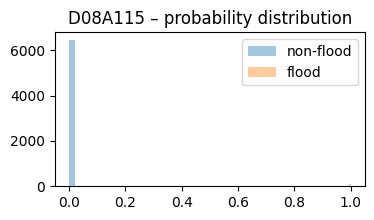

== D08A115 ==
thr= 0.01  FP=8   FN=0    prec=0.930  rec=1.000
thr= 0.05  FP=5   FN=0    prec=0.955  rec=1.000
thr=  0.1  FP=3   FN=0    prec=0.972  rec=1.000
thr=  0.5  FP=3   FN=0    prec=0.972  rec=1.000
thr=  0.9  FP=2   FN=3    prec=0.981  rec=0.972
thr= 0.95  FP=2   FN=3    prec=0.981  rec=0.972
thr= 0.98  FP=2   FN=5    prec=0.981  rec=0.953
thr=0.995  FP=2   FN=6    prec=0.980  rec=0.943



In [7]:
for code in STATIONS:
    plot_hist(code)
    print(f"== {code} ==")
    for thr in [0.01,0.05,0.10,0.5,0.9,0.95,0.98,0.995]:
        fp, fn, p, r = eval_thr(code, thr)
        print(f"thr={thr:>5}  FP={fp:<3} FN={fn:<3}  prec={p:.3f}  rec={r:.3f}")
    print()


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, average_precision_score

print("\n### Random 70/30 split (stratified) – per station\n")
rand_rows = []
for code in STATIONS:
    df = build_features(load_station(code))
    feat_cols = [c for c in df.columns if c.startswith(('rain_sum','dis_lag','dis_rate','API'))]

    X = df[feat_cols]
    y = df['flood']

    # stratified random split
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=0.30, random_state=42, stratify=y)

    neg, pos = np.bincount(y_tr)
    clf = XGBClassifier(
        learning_rate=0.05, n_estimators=800, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, random_state=42,
        scale_pos_weight=neg/pos, eval_metric='aucpr')
    clf.fit(X_tr, y_tr)

    y_prob = clf.predict_proba(X_te)[:, 1]
    y_pred = (y_prob > 0.5).astype(int)
    rpt = classification_report(y_te, y_pred, output_dict=True)

    rand_rows.append({
        'station': code,
        'precision': round(rpt['1']['precision'], 3),
        'recall':    round(rpt['1']['recall'],    3),
        'f1':        round(rpt['1']['f1-score'],  3),
        'PR-AUC':    round(average_precision_score(y_te, y_prob), 3),
        'test_floods': int(y_te.sum())
    })

pd.DataFrame(rand_rows).set_index('station')


### Random 70/30 split (stratified) – per station



,precision,recall,f1,PR-AUC,test_floods
station,,,,,
D08A071,1.000,0.999,0.999,1.0,1376
D08A084,0.998,1.000,0.999,1.0,891
D08A115,0.999,0.999,0.999,1.0,1177


## 3. Enter your chosen thresholds below

In [9]:
# ← Edit these values after manual exploration
MY_THR = {'D08A071': 0.980,
          'D08A084': 0.982,
          'D08A115': 0.95}

overall_true = []
overall_pred = []

print("Per‑station metrics with custom thresholds\n")
for code in STATIONS:
    thr = MY_THR[code]
    fp, fn, p, r = eval_thr(code, thr)
    print(f"{code}: thr={thr}  FP={fp}  FN={fn}  precision={p:.3f}  recall={r:.3f}")
    pred = (probs_dict[code] > thr).astype(int)
    overall_true.append(ytrue_dict[code])
    overall_pred.append(pd.Series(pred, index=ytrue_dict[code].index))

print("\nCombined confusion matrix:")
print(confusion_matrix(pd.concat(overall_true),
                       pd.concat(overall_pred),
                       labels=[0,1]))


Per‑station metrics with custom thresholds

D08A071: thr=0.98  FP=1  FN=1  precision=1.000  recall=1.000
D08A084: thr=0.982  FP=2  FN=1  precision=0.997  recall=0.999
D08A115: thr=0.95  FP=2  FN=3  precision=0.981  recall=0.972

Combined confusion matrix:
[[20880     5]
 [    5  2950]]
